In [1]:
import os
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
"""for i, row in tqdm(id_list.iterrows()):
    point = row['Service Point']
    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')
    example_ts.index = pd.to_datetime(example_ts.index)
    example_ts = example_ts.resample('H').mean()
    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)
    example_ts = example_ts['2021-02':'2021-02']
    
    
    # condition with energy that outage happen
    energy = example_ts.iloc[:, 0]
    Q3 = np.quantile(energy, 1)
    Q1 = np.quantile(energy, 0.1)
    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)

    meter_used = example_ts.iloc[:, 1]
    Q3 = np.quantile(meter_used, 1)
    Q1 = np.quantile(meter_used, 0.1)
    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)
    
    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])
    total = len(example_ts['2021-02-12':'2021-02-20'])
    percent = round(happen / total * 100, 5)
    id_list.loc[i, 'is_effected'] = 1 if percent != 0.0 else 0
    id_list.loc[i, 'temporal_percentage'] = percent"""

"for i, row in tqdm(id_list.iterrows()):\n    point = row['Service Point']\n    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')\n    example_ts.index = pd.to_datetime(example_ts.index)\n    example_ts = example_ts.resample('H').mean()\n    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)\n    example_ts = example_ts['2021-02':'2021-02']\n    \n    \n    # condition with energy that outage happen\n    energy = example_ts.iloc[:, 0]\n    Q3 = np.quantile(energy, 1)\n    Q1 = np.quantile(energy, 0.1)\n    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)\n\n    meter_used = example_ts.iloc[:, 1]\n    Q3 = np.quantile(meter_used, 1)\n    Q1 = np.quantile(meter_used, 0.1)\n    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)\n    \n    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])\n    total = len(example_ts

In [6]:
id_list = pd.read_csv('temporal_percentage1.csv')
id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
commercial_type = ['SM OFFICE CONDO', 'RESTAURANT',
       'OFFICE MED 10-35', 'OFFICE LG >35000', 'OFFICE (SMALL)',
       'LG OFFICE CONDO', 'REGIONAL SHOP CT', 'FAST FOOD REST',
       'SM STORE <10K SF','CONVENIENCE STOR',
       'COMMERCIAL IMPROVED', 'COMMERCIAL SPACE CONDOS',
       'OFF HI-RISE >= 6']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()
comm_type_id_list = id_list[id_list['buildingType'].isin(commercial_type)].copy()
other_type = [x for x in id_list['buildingType'].unique() if x not in res_type and x not in  commercial_type]
other_type_id_list = id_list[id_list['buildingType'].isin(other_type)].copy()
res_type_id_list

,Service Point,zipCode,rate,buildingType,meterCount,squareFt,is_effected,temporal_percentage
2,-1609,78759,E-SEC1,SINGLE FAMILY,31,6.123583e+04,1.0,38.42593
3,-1608,78759,E-RES,SINGLE FAMILY,7996,1.772336e+07,1.0,31.48148
12,-1599,78759,E-SEC2,MULTIFAMILY,55,5.847722e+05,1.0,17.12963
13,-1598,78759,E-SEC1,MULTIFAMILY,723,7.835178e+06,1.0,28.24074
14,-1597,78759,E-RES,MULTIFAMILY,9754,1.018324e+07,1.0,30.09259
...,...,...,...,...,...,...,...,...
606,-1004,78617,E-RES,MOHO DOUBLE REAL,78,8.360207e+04,1.0,17.59259
607,-1003,78617,E-RES,MOHO DOUBLE PP,33,2.008650e+04,1.0,20.37037
608,-1002,78617,E-RES,DUPLEX,254,1.685170e+05,1.0,1.85185
609,-1001,78617,E-RES,"1 FAM DWELLING, ACCESSORY DWELLING UNIT",21,1.874300e+04,1.0,9.25926


In [5]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample

,Energy_kwh
-1002 kWh DateTime,
2017-01-01,1.066800
2017-01-02,3603.728604
2017-01-03,4820.952005
2017-01-04,5877.793034
2017-01-05,6862.671227
...,...
2021-09-27,8883.985233
2021-09-28,10725.229206
2021-09-29,9266.954388


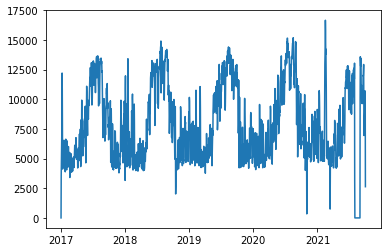

In [7]:
plt.plot(prepare_data(-1002))
s=prepare_data(-1002)
s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
s

In [8]:
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
cool_points

time
2017-01-04 00:00:00+00:00     5.9
2017-01-05 00:00:00+00:00     8.6
2017-01-06 00:00:00+00:00    -1.1
2017-01-07 00:00:00+00:00    -0.9
2017-01-08 00:00:00+00:00     3.0
                             ... 
2021-01-23 00:00:00+00:00    13.8
2021-01-26 00:00:00+00:00    14.9
2021-01-27 00:00:00+00:00    12.4
2021-01-28 00:00:00+00:00     7.8
2021-01-29 00:00:00+00:00    11.8
Name: tavg, Length: 363, dtype: float64

In [9]:
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
weather_austin_hourl_pred

time
2016-01-01 00:00:00    10.6
2016-01-01 01:00:00    10.2
2016-01-01 02:00:00    10.2
2016-01-01 03:00:00    10.2
2016-01-01 04:00:00    10.2
                       ... 
2021-12-31 19:00:00    23.5
2021-12-31 20:00:00    25.2
2021-12-31 21:00:00    27.4
2021-12-31 22:00:00    27.4
2021-12-31 23:00:00    27.4
Name: temp, Length: 52608, dtype: float64

In [10]:
train_set=s[:'2021-02-10']
test_set=s['2021-02-11':'2021-02-19']
resi_train_service=train_set[train_set>0]
resi_train_service1=resi_train_service.dropna()

Text(0.5, 1.0, 'residential_outlier_visualization')

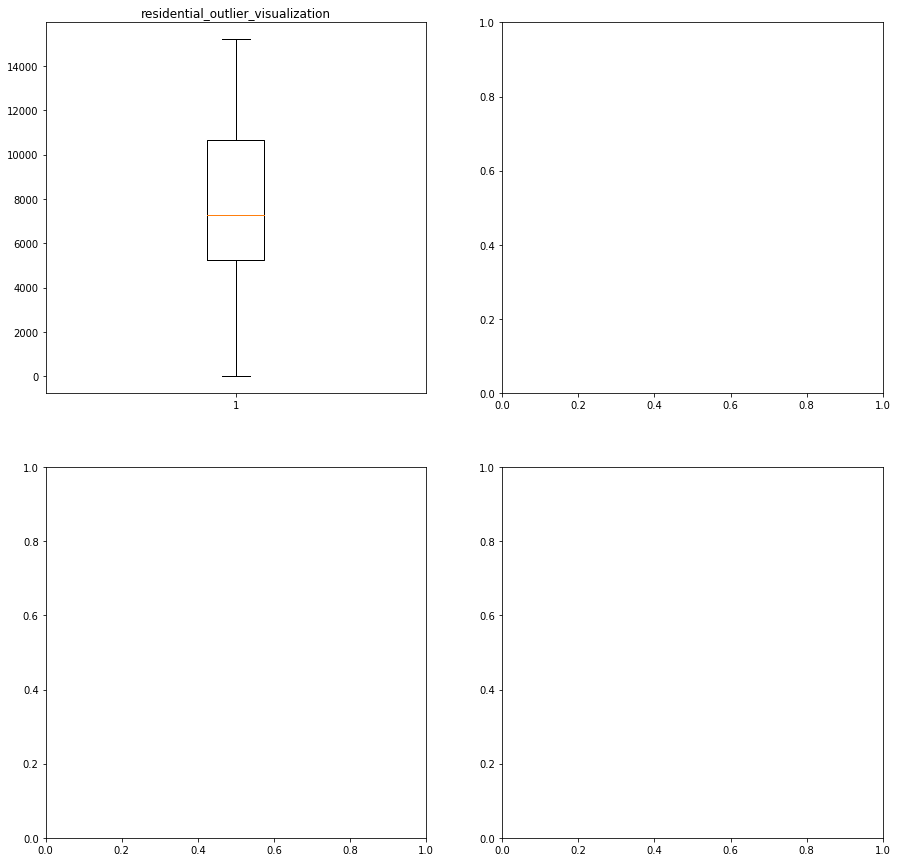

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs[0,0].boxplot(train_set[train_set.columns[0]])
axs[0,0].set_title('residential_outlier_visualization')
# ONLY RESIDENTIAL HAS OUTLIERS

Text(0.5, 1.0, 'new_residential_outlier_visualization')

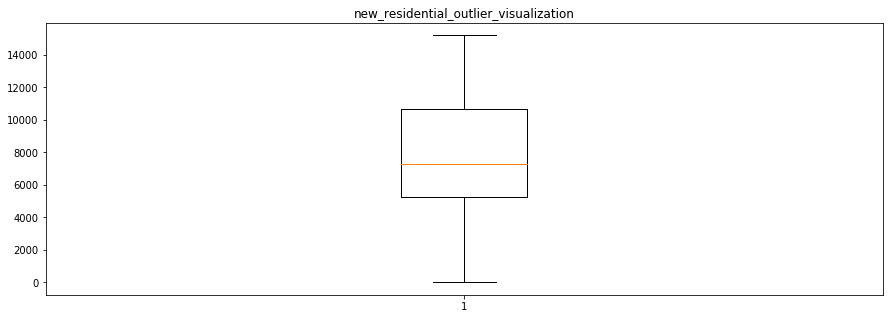

In [12]:
#Q3= train_set['Energy_kwh'].quantile(0.95)
#outliers are explainable and thus included
fig, ax1 = plt.subplots(1, figsize=(15,5))
ax1.boxplot(resi_train_service1[resi_train_service1.columns[0]])
ax1.set_title('new_residential_outlier_visualization')

In [15]:
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts

In [16]:
k=5
residential_train_Data_servicepoint=make_features(resi_train_service1,'daily')
residential_test_data_service_point=make_features(test_set,'daily')
resi_winter_temp=residential_test_data_service_point['TMP']
residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
residential_test_data_service_point

,Energy_kwh,dayofyear_cos,dayofyear_sim,month_cos,month_sin,year,TMP
-1002 kWh DateTime,,,,,,,
2021-02-11,11792.794220,0.749826,0.661635,0.5,0.866025,2021,4.1
2021-02-12,12982.356636,0.738326,0.674444,0.5,0.866025,2021,0.8
2021-02-13,13557.209969,0.726608,0.687053,0.5,0.866025,2021,-0.4
2021-02-14,14430.583771,0.714673,0.699458,0.5,0.866025,2021,-0.4
2021-02-15,16676.288376,0.702527,0.711657,0.5,0.866025,2021,-5.9
2021-02-16,15815.375992,0.690173,0.723644,0.5,0.866025,2021,-6.5
2021-02-17,13817.198380,0.677615,0.735417,0.5,0.866025,2021,-4.2
2021-02-18,14245.777191,0.664855,0.746972,0.5,0.866025,2021,-1.5
2021-02-19,12908.476776,0.651899,0.758306,0.5,0.866025,2021,-0.4


-0.3163111587830961


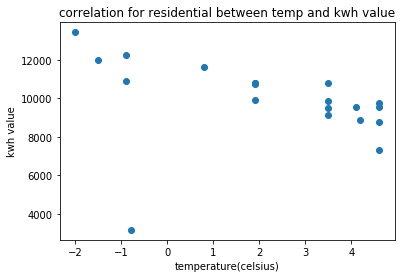

In [28]:
resi_below_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']<5]
plt.scatter(resi_below_5[resi_below_5.columns[-1]],resi_below_5[resi_below_5.columns[0]])
plt.xlabel('temperature(celsius)')
plt.ylabel('kwh value')
plt.title('correlation for residential between temp and kwh value')
print(resi_below_5[resi_below_5.columns[-1]].corr(resi_below_5[resi_below_5.columns[0]]))



In [29]:
for index,row in resi_below_5[resi_below_5['TMP']<5].iterrows():
    if row['Energy_kwh']<8000 and row['TMP']<0:
        print(row['Energy_kwh'],row['TMP'])
        resi_below_5_1=resi_below_5.drop(index)      

3166.397605895996 -0.8


-0.8718103097666079


LinearRegression()

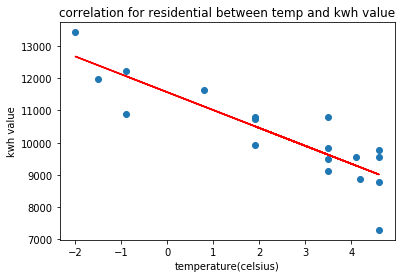

In [30]:
q=resi_below_5_1[resi_below_5_1['TMP']<5]
plt.scatter(q['TMP'],q['Energy_kwh'])
plt.xlabel('temperature(celsius)')
plt.ylabel('kwh value')
plt.title('correlation for residential between temp and kwh value')
m, b = np.polyfit(q['TMP'], q['Energy_kwh'], 1)
plt.plot(q['TMP'], m*q['TMP'] + b,color='red')
print(q['TMP'].corr(q['Energy_kwh']))
train_below_5=q[q.columns[k:]]
test_below_5=q['Energy_kwh']
lr_5=LinearRegression()
lr_5.fit(train_below_5,test_below_5)


0.6874161899600646


LinearRegression()

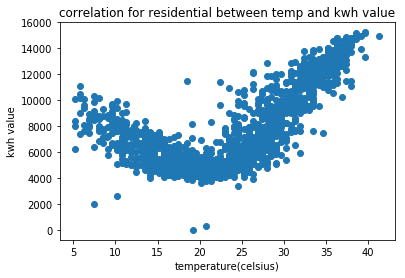

In [31]:
resi_test_more_than_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']>5]
plt.scatter(resi_test_more_than_5['TMP'],resi_test_more_than_5['Energy_kwh'])
plt.xlabel('temperature(celsius)')
plt.ylabel('kwh value')
plt.title('correlation for residential between temp and kwh value')
print(resi_test_more_than_5['TMP'].corr(resi_test_more_than_5['Energy_kwh']))
train_above_5=resi_test_more_than_5[resi_test_more_than_5.columns[k:]]
test_above_5=resi_test_more_than_5['Energy_kwh']
lr_above_5=LinearRegression()
lr_above_5.fit(train_above_5,test_above_5)


In [33]:
winter_test_data=residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
winter_data_below_5=winter_test_data[winter_test_data['TMP']<5]
winter_data_above_5=winter_test_data[winter_test_data['TMP']>5]
winter_data_below_5

,year,TMP
-1002 kWh DateTime,,
2021-02-11,2021,4.1
2021-02-12,2021,0.8
2021-02-13,2021,-0.4
2021-02-14,2021,-0.4
2021-02-15,2021,-5.9
2021-02-16,2021,-6.5
2021-02-17,2021,-4.2
2021-02-18,2021,-1.5
2021-02-19,2021,-0.4


In [35]:
residential_test_data_service_point

,Energy_kwh,dayofyear_cos,dayofyear_sim,month_cos,month_sin,year,TMP
-1002 kWh DateTime,,,,,,,
2021-02-11,11792.794220,0.749826,0.661635,0.5,0.866025,2021,4.1
2021-02-12,12982.356636,0.738326,0.674444,0.5,0.866025,2021,0.8
2021-02-13,13557.209969,0.726608,0.687053,0.5,0.866025,2021,-0.4
2021-02-14,14430.583771,0.714673,0.699458,0.5,0.866025,2021,-0.4
2021-02-15,16676.288376,0.702527,0.711657,0.5,0.866025,2021,-5.9
2021-02-16,15815.375992,0.690173,0.723644,0.5,0.866025,2021,-6.5
2021-02-17,13817.198380,0.677615,0.735417,0.5,0.866025,2021,-4.2
2021-02-18,14245.777191,0.664855,0.746972,0.5,0.866025,2021,-1.5
2021-02-19,12908.476776,0.651899,0.758306,0.5,0.866025,2021,-0.4


In [23]:
pred_below_5=lr_5.predict(winter_data_below_5)
#pred_above_5=lr_above_5.predict(winter_data_above_5)

In [24]:
pred_below_5

array([ 8973.74732812, 10692.57220491, 11317.59943283, 11317.59943283,
       14182.30756081, 14494.82117477, 13296.85232125, 11890.54105843,
       11317.59943283])

In [25]:
"""a=pred_above_5[:10]
b=pred_below_5
c=pred_above_5[10:]"""
a=pred_below_5
frames=[a]
predictions = np.concatenate(frames)
predictions

array([ 8973.74732812, 10692.57220491, 11317.59943283, 11317.59943283,
       14182.30756081, 14494.82117477, 13296.85232125, 11890.54105843,
       11317.59943283])

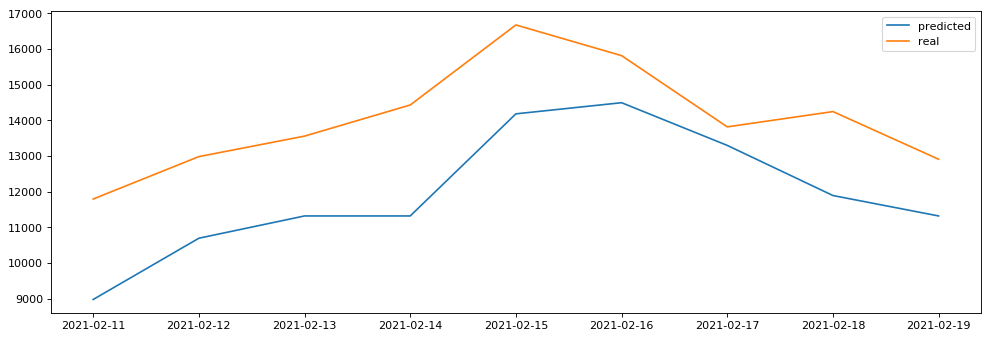

In [26]:
figure(figsize=(15,5), dpi=80)
plt.plot(residential_test_data_service_point.index,predictions,label='predicted')
plt.plot(residential_test_data_service_point.index,residential_test_data_service_point['Energy_kwh'],label='real')
plt.legend()
plt.show()

Text(0.5, 1.0, '-1597_servicepoint')

<Figure size 1200x800 with 0 Axes>

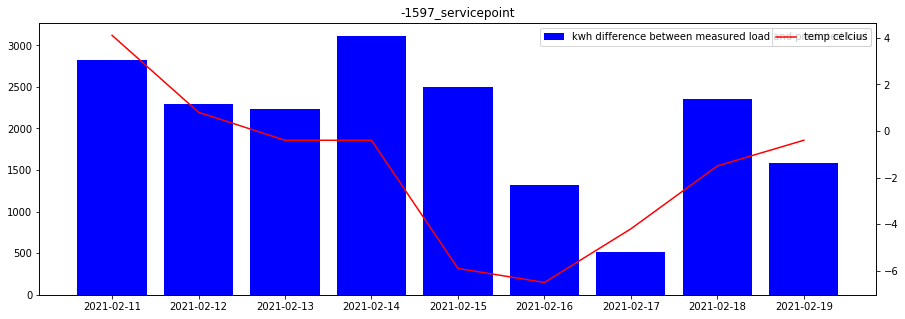

In [27]:
difference=residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']-pred_below_5
di=pd.DataFrame(difference)
di['timestamp']=di.index
figure(figsize=(15,10), dpi=80)
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(di['timestamp'],di['Energy_kwh'],color='blue')
ax1.legend(['kwh difference between measured load and predicted load'])

ax2=ax1.twinx()
ax2.plot(residential_test_data_service_point['TMP']['2021-02-11':'2021-02-19'],color='red')
ax2.legend(['temp celcius'])
plt.title('-1597_servicepoint')